# <span style="color:#ff1414"> BEDtools analysis. </span>

This is a script to answer research questions outlined elsewhere. In summary, this script:

1. compares methylation results between different methylation-callers, and between different methylation sequencing methods.

2. make files for different cutoffs of methylation accuracy


Note:
- PB/pb = PacBio
- ONT/ont = Oxford Nanopore Technology
- NP = Nanopolish

In [4]:
import pybedtools
from pybedtools import BedTool


#import numpy 


import matplotlib.patches as mpatches

 # need for  stats

from scipy.stats import wilcoxon
from scipy.stats import spearmanr

In [49]:
# load modules
import os
import glob
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pprint
import pandas as pd
import numpy as np
from pybedtools import BedTool
import scipy
from scipy.stats import fisher_exact

In [3]:
DIRS['WINDOW_OUTPUT'] = os.path.join(DIRS['BASE2'], 'windows')
DIRS['WINDOW_INPUT'] = os.path.join(DIRS['BASE2'], 'input_for_windows')
DIRS['REF'] = '/home/anjuni/Pst_104_v13_assembly/'

DIRS['COVERAGE'] = os.path.join(DIRS['BASE2'], 'coverage')
DIRS['TE_SF'] = os.path.join(DIRS['COVERAGE'], 'superfamily_files')
DIRS['RNA'] = os.path.join(DIRS['BASE2'], 'rna_counts')
DIRS['edgeR'] = os.path.join(DIRS['RNA'], 'edgeR_output')
DIRS['TRIALS'] = os.path.join(DIRS['RNA'], 'trials_tsv')
DIRS['MEAN_STD'] = os.path.join(DIRS['RNA'], 'average_and_stdev')
DIRS['GENE'] = os.path.join(DIRS['COVERAGE'], 'gene_level')
DIRS['GENE_ANNO'] = os.path.join(DIRS['GENE'], 'gene_anno')
DIRS['BOTH_U_D'] = os.path.join(DIRS['GENE'], 'both_upstream_downstream')
DIRS['DOWN_STR'] = os.path.join(DIRS['GENE'], 'downstream')
DIRS['UP_STR'] = os.path.join(DIRS['GENE'], 'upstream')
DIRS['TSS'] = os.path.join(DIRS['GENE'], 'tss_6mA_only')

In [50]:
#First we need to define the base dirs
DIRS ={}
DIRS['BASE1'] = '/home/anjuni/methylation_calling/pacbio'
DIRS['BASE2'] = '/home/anjuni/analysis'
DIRS['BED_INPUT'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'sequencing_comparison')
DIRS['GFF_INPUT'] = os.path.join(DIRS['BASE2'], 'gff_output')
DIRS['FIGURES'] = os.path.join(DIRS['BASE2'], 'figures')
DIRS['FEATURES'] = os.path.join(DIRS['BASE2'], 'coverage', 'feature_files')
DIRS['RAND'] = os.path.join(DIRS['BASE2'], 'coverage', 'randomisation')
DIRS['I_FROM_C'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'intersects_from_cutoffs')
DIRS['BED_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs')
DIRS['6MA_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_6mA')
DIRS['5MC_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_5mC')

In [8]:
#Quick chech if directories exist
for value in DIRS.values():
    if not os.path.exists(value):
        print('%s does not exist' % value)

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs does not exist


In [79]:
#Make filepaths
bed_file_list = [fn for fn in glob.iglob('%s/*.bed' % DIRS['BED_INPUT'], recursive=True)]
gff_file_list = [fn for fn in glob.iglob('%s/*anno.gff3' % DIRS['GFF_INPUT'], recursive=True)]
te_file_list = [fn for fn in glob.iglob('%s/*.gff' % DIRS['GFF_INPUT'], recursive=True)]

In [80]:
#Check that the list works
print(*bed_file_list, sep='\n')
print(*gff_file_list, sep='\n')
print(*te_file_list, sep='\n')

/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_tombo_sorted.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_tombo_np.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_tombo_np.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_np_tombo.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_hc_tombo_sorted.CpG.plus.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_s_nanopolish.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/nanopolish_rerun_subtract.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_hc_nanopolish_sorted.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_tombo_np.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/nano_plus_tombo_overlap.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_tombo_sorted.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5m

## <span style='color:deeppink'> 1. Comparing methylation sequencing methods <span/>

In [8]:
%%bash

# find overlap between 6mA from PacBio and Nanopore for 6mA data

pb=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed # use basecall accuracy instead of Phred score
ont=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed # use sites with non-zero methylation

out1=/home/anjuni/analysis/bedtools_output/sequencing_comparison/6mA_pb_ont.bed
out2=/home/anjuni/analysis/bedtools_output/sequencing_comparison/6mA_ont_pb.bed

echo $pb
echo $ont

bedtools intersect -a $pb -b $ont > $out1
bedtools intersect -a $ont -b $pb > $out2

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed


In [9]:
# Function to count the number of sites in each file
def count_sites(file_list):
    """Outputs a dictionary of each cutoff file and the number of sites it has."""
    count_dict = {}
    for file in file_list:
        with open(file) as in_file:
            count = 0
            for line in in_file:
                count += 1
        count_dict[file.split('/')[-1]] = count
    return count_dict

In [81]:
#check how many overlapping sites there were
tech_overlap_dict = count_sites(bed_file_list)

In [82]:
tech_overlap_dict

{'5mC_CpG_np_tombo.bed': 3708640,
 '5mC_CpG_tombo_np.bed': 3708640,
 '5mC_hc_nanopolish_sorted.bed': 3783438,
 '5mC_hc_tombo_sorted.CpG.bed': 5167951,
 '5mC_hc_tombo_sorted.CpG.plus.bed': 5167951,
 '5mC_hc_tombo_sorted.bed': 67308386,
 '5mC_minus_tombo_sorted.bed': 34272921,
 '5mC_nanopolish_sorted.bed': 5302131,
 '5mC_np_tombo.bed': 1681653,
 '5mC_plus_CpG_np_tombo.bed': 3708640,
 '5mC_plus_CpG_tombo_np.bed': 3708640,
 '5mC_plus_tombo_sorted.bed': 34263097,
 '5mC_rerun_s_nanopolish.bed': 5302131,
 '5mC_s_nanopolish.bed': 5302131,
 '5mC_tombo_np.bed': 1681653,
 '5mC_tombo_sorted.bed': 68536018,
 '6mA_hc_tombo_sorted.bed': 83451878,
 '6mA_ont_pb.bed': 84733,
 '6mA_prob_smrtlink_sorted.bed': 88932,
 '6mA_tombo_sorted.bed': 85779879,
 'nano_minus_tombo_overlap.bed': 0,
 'nano_plus_tombo_overlap.bed': 5221309,
 'nanopolish_rerun_subtract.bed': 0}

In [27]:
#check how many overlapping sites there were
print('Total adenine sites:', '\t', tech_overlap_dict['6mA_tombo_sorted.bed'])
print('Nanopore 6mA sites:', '\t', tech_overlap_dict['6mA_hc_tombo_sorted.bed'])
print('PacBio 6mA sites:', '\t', tech_overlap_dict['6mA_prob_smrtlink_sorted.bed'])
print('Overlapping 6mA sites:', '\t', tech_overlap_dict['6mA_ont_pb.bed'])

Total adenine sites: 	 85779879
Nanopore 6mA sites: 	 83451878
PacBio 6mA sites: 	 88932
Overlapping 6mA sites: 	 84733


In [45]:
# Descriptive Statistics
print('Percentage overlap between PacBio and Nanopore as a proportion of PB sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['6mA_ont_pb.bed']/tech_overlap_dict['6mA_prob_smrtlink_sorted.bed']))
print('Percentage overlap between PacBio and Nanopore as a proportation of ONT sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['6mA_ont_pb.bed']/tech_overlap_dict['6mA_hc_tombo_sorted.bed']))
print('Percentage overlap between PacBio and Nanopore as a proportion of adenine:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['6mA_ont_pb.bed']/tech_overlap_dict['6mA_tombo_sorted.bed']))
print('PacBio sites as a proportion of adenine:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['6mA_prob_smrtlink_sorted.bed']/tech_overlap_dict['6mA_tombo_sorted.bed']))
print('Nanopore sites as a proportion of adenine:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['6mA_hc_tombo_sorted.bed']/tech_overlap_dict['6mA_tombo_sorted.bed']))

Percentage overlap between PacBio and Nanopore as a proportion of PB sites: 	 95.278%
Percentage overlap between PacBio and Nanopore as a proportation of ONT sites: 	 0.102%
Percentage overlap between PacBio and Nanopore as a proportion of adenine: 	 0.099%
PacBio sites as a proportion of adenine: 	 0.104%
Nanopore sites as a proportion of adenine: 	 97.286%


#### <span style='color:deeppink'> Observations <span/>

Very high similarity between Nanopore and PacBio, when compared to PacBio. But PacBio sites are only a small fraction of Tombo sites, and only include highly accurate sites.

When overlapping PacBio and all Nanopore (Tombo) sites, which are all adenines in the genome, there was a higher overlap (88932) than when overlapping only non-zero PB and ONT sites (84733). This indicates PB detected sites that Nanopore did not, and these were high probability sites that were missed, as PB only had high probability (>99% basecall accuracy) sites.

There are also more overlapped sites when using the zero-probability sites from tombo, compared to only using only high confidence sites from both. This also suggests that Tombo/Nanopore had missed some methylated sites. In addition, Tombo is likely to have a high rate of false positives, as it detected 97% of adenines as methylated.

## <span style='color:#ff14ff'> 2. Comparing methylation detection methods <span/>

In [3]:
%%bash

# compare overlap between Tombo and Nanopolish for 5mC data
np=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
tombo=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed

out1=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_np_tombo.bed
out2=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_tombo_np.bed

echo $np
echo $tombo

bedtools intersect -a $np -b $tombo > $out1
bedtools intersect -a $tombo -b $np > $out2

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed


In [52]:
#check how many overlapping sites there were
print('Total cytosine sites:', '\t', tech_overlap_dict['5mC_tombo_sorted.bed'])
print('Total CpG sites:', '\t', tech_overlap_dict['5mC_nanopolish_sorted.bed'])
print('Tombo 5mC sites:', '\t', tech_overlap_dict['5mC_hc_tombo_sorted.bed'])
print('Nanopolish 5mC sites:', '\t', tech_overlap_dict['5mC_hc_nanopolish_sorted.bed'])
print('Overlapping 5mC sites:', '\t', tech_overlap_dict['5mC_tombo_np.bed'])

Total cytosine sites: 	 68536018
Total CpG sites: 	 5302131
Tombo 5mC sites: 	 67308386
Nanopolish 5mC sites: 	 3783438
Overlapping 5mC sites: 	 1681653


In [58]:
# Descriptive Statistics
print('Percentage overlap between Tombo and Nanopolish as a proportion of Nanopolish sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_tombo_np.bed']/tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']))
print('Percentage overlap between Tombo and Nanopolish as a proportation of Tombo sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_tombo_np.bed']/tech_overlap_dict['5mC_hc_tombo_sorted.bed']))
print('Percentage of overlap between Tombo and Nanopolish as a proportion of CpG sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_tombo_np.bed']/tech_overlap_dict['5mC_nanopolish_sorted.bed']))
print('Percentage overlap between Tombo and Nanopolish as a proportion of cytosine:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_tombo_np.bed']/tech_overlap_dict['5mC_tombo_sorted.bed']))
print('Nanopolish sites as a proportion of CpG sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']/tech_overlap_dict['5mC_nanopolish_sorted.bed']))
print('Tombo sites as a proportion of cytosine:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_hc_tombo_sorted.bed']/tech_overlap_dict['5mC_tombo_sorted.bed']))
print('Nanopolish sites as a proportion of cytosine:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']/tech_overlap_dict['5mC_tombo_sorted.bed']))

Percentage overlap between Tombo and Nanopolish as a proportion of Nanopolish sites: 	 44.448%
Percentage overlap between Tombo and Nanopolish as a proportation of Tombo sites: 	 2.498%
Percentage of overlap between Tombo and Nanopolish as a proportion of CpG sites: 	 31.717%
Percentage overlap between Tombo and Nanopolish as a proportion of cytosine: 	 2.454%
Nanopolish sites as a proportion of CpG sites: 	 71.357%
Tombo sites as a proportion of cytosine: 	 98.209%
Nanopolish sites as a proportion of cytosine: 	 5.520%


#### <span style='color:#ff14ff'> Observations <span/>
While adenine methylation had high similarity between ONT and PB, cytosine methylation had only 44% similarity between NP and tombo. This is likely because NP only has CpG sites, and Tombo has all cytosine sites, so Tombo will detect far more potentially methylated sites, even those that are not CpG sites, so it will have far more sites than NP to begin with.
Again, Tombo is likely to have a high amount of false positives, as 98% of cytosines are methylated. Nanopolish has 71% CpG methylation, which is similar to the CpG methylation rate in mammals, which is 70-80% (Jabbari & Bernardi, 2004). Therefore, Nanopolish is likely to be more accurate than Tombo.
The overlap between Tombo and Nanopolish suggests only a 2.5% rate of cytosine methylation, which is half the 5% cytosine methylation rate detected by Brar et al. (2018).

-source: https://www.sciencedirect.com/science/article/pii/S0378111904000836?via%3Dihub (Jabbari & Bernardi, 2004)

### <span style='color:#ff14ff'> 2.A Comparing CpG site methylation. <span/>

In [60]:
#check how many cytosine sites and CpG sites there are
print('CpG sites:', '\t', tech_overlap_dict['5mC_nanopolish_sorted.bed'])
print('Cytosine sites:', tech_overlap_dict['5mC_tombo_sorted.bed'])

CpG sites: 	 5302131
Cytosine sites: 68536018


In [61]:
# Descriptive Statistics
print('Percentage of CpG sites as a proportion of cytosine sites:', "{0:.3f}%".format(100*tech_overlap_dict['5mC_nanopolish_sorted.bed']/tech_overlap_dict['5mC_tombo_sorted.bed']))

Percentage of CpG sites as a proportion of cytosine sites: 7.736%


#### <span style='color:#ff14ff'> Solution <span/>
1. Make a file of methylated CpG sites detected by Tombo.
2. Intersect this with methylated (CpG) sites detected by Nanopolish.

I will be overlapping CpG sites from Tombo and NP, because NP only has CpG sites and Tombo has all cytosine sites.
So from the start, the overlap wouldn't have been accurate, because tombo considers sites that NP does not.

In [ ]:
%%bash

# make a file of CpG sites from tombo
all_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_nanopolish_sorted.bed
all_tombo=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed
tombo_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed

bedtools intersect -a $all_tombo -b $all_cpg > $tombo_cpg

In [ ]:
%%bash

# intersect Tombo and NP CpG sites
tombo_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed
np_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
m_tombo_cpg=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_tombo_np.bed
m_np_cpg=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_np_tombo.bed

bedtools intersect -a $tombo_cpg -b $np_cpg > $m_tombo_cpg
bedtools intersect -a $np_cpg -b $tombo_cpg > $m_np_cpg

In [77]:
#check how many overlapping sites there were
print('Total CpG sites:', '\t', tech_overlap_dict['5mC_nanopolish_sorted.bed'])
print('Nanopolish methylated CpG sites:', '\t', tech_overlap_dict['5mC_hc_nanopolish_sorted.bed'])
print('Tombo methylated CpG sites:', '\t', tech_overlap_dict['5mC_hc_tombo_sorted.CpG.bed'])
print('Overlapping methylated CpG sites:', '\t', tech_overlap_dict['5mC_CpG_tombo_np.bed'])

Total CpG sites: 	 5302131
Nanopolish methylated CpG sites: 	 3783438
Tombo methylated CpG sites: 	 5167951
Overlapping methylated CpG sites: 	 3708640


In [74]:
# Descriptive Statistics
print('Percentage overlap between Tombo and Nanopolish as a proportion of NP CpG sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_CpG_tombo_np.bed']/tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']))
print('Percentage overlap between Tombo and Nanopolish as a proportation of Tombo CpG sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_CpG_tombo_np.bed']/tech_overlap_dict['5mC_hc_tombo_sorted.CpG.bed']))
print('Percentage of overlapping CpG sites methylated:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_CpG_tombo_np.bed']/tech_overlap_dict['5mC_nanopolish_sorted.bed']))

Percentage overlap between Tombo and Nanopolish as a proportion of NP CpG sites: 	 98.023%
Percentage overlap between Tombo and Nanopolish as a proportation of Tombo CpG sites: 	 71.762%
Percentage of CpG sites methylated: 	 69.946%


#### <span style='color:#ff14ff'> Observations <span/>
While the overlap between Tombo and NP changed to 98% after only comparing CpG sites, the nearly 50% overlap when comparing cytosine methylation may be because NP only considers one strand while Tombo considers both.
The Tombo cpG site was generated by intersecting Tombo methylated sites with all Nanopolish sites, which are all CpG sites.

This may be resolved by using only the plus file from Tombo and comparing its results to NP.

### <span style='color:#ff14ff'> 2.B Test out whether Nanopolish only detects (+) strand <span/>
Intersect tombo 5mC (-) strand file with nanopolish file to see if there is overlap. Then intersect the tombo (+) strand with nanopolish.

The 44% match may just be because I, for some reason, put all the nanopolish sites as (+) strand when making the original BED file :P

In [147]:
%%bash

#Sort the initial tombo bed files, because they were not sorted and slowed down the intersection

tombo_minus=/home/anjuni/methylation_calling/pacbio/input/bed_files/initial_bed_files/5mC_minus_tombo.bed
tombo_plus=/home/anjuni/methylation_calling/pacbio/input/bed_files/initial_bed_files/5mC_plus_tombo.bed
nanopolish=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_s_nanopolish.bed

sort_tombo_minus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_minus_tombo_sorted.bed
sort_tombo_plus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_plus_tombo_sorted.bed

sortBed -i $tombo_minus > $sort_tombo_minus
sortBed -i $tombo_plus > $sort_tombo_plus

In [148]:
%%bash

#Intersect the (+) and (-) BED files with nanopolish file
#to see whether Nanopolish has methylation-calls on both strands :)

sort_tombo_minus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_minus_tombo_sorted.bed
sort_tombo_plus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_plus_tombo_sorted.bed
nanopolish=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_s_nanopolish.bed

intersectBed -a $nanopolish -b $sort_tombo_minus > /home/anjuni/methylation_calling/pacbio/input/bed_files/nano_minus_tombo_overlap.bed
intersectBed -a $nanopolish -b $sort_tombo_plus > /home/anjuni/methylation_calling/pacbio/input/bed_files/nano_plus_tombo_overlap.bed

In [85]:
#Compare the number of NP sites to Tombo sites on the forward and reverse strand

print('The number of CpG sites captured by Nanopolish:', '\t', tech_overlap_dict['5mC_nanopolish_sorted.bed'])
print('The number of overlapping (+) strand sites captured by Nanopolish and by Tombo:', '\t', tech_overlap_dict['nano_plus_tombo_overlap.bed'])
print('The number of overlapping (-) strand sites captured by Nanopolish and by Tombo:', '\t', tech_overlap_dict['nano_minus_tombo_overlap.bed'])

The number of CpG sites captured by Nanopolish: 	 5302131
The number of overlapping (+) strand sites captured by Nanopolish and by Tombo: 	 5221309
The number of overlapping (-) strand sites captured by Nanopolish and by Tombo: 	 0


In [83]:
print('Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of NP sites:', "{0:.3f}%".format(100*tech_overlap_dict['nano_plus_tombo_overlap.bed']/tech_overlap_dict['5mC_nanopolish_sorted.bed']))

Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of NP sites: 98.476%


There is a 98% similarity between Nanopolish sites and Tombo forward strand sites, but no similarity between Nanopolish sites and Tombo reverse strand sites, indicating that the 44% similarity between Nanopolish and Tombo from earlier was because Nanopolish only detected methylation on the forward strand.

I am currently re-running Nanopolish methylation-calling in case there was a mistake in the code earlier, causing it to ignore the reverse strand. Re-running the test run for pcontig_109 showed no difference in output to the previous one. They had the same number of sites (46801) and had the same output for the first 10 lines and last 10 lines. Now I think there wasn't a mistake because I only copied the index files to a new folder to save them back to the output folder, while a copy of all index files remained in the original fastq folder. This allowed methylation-calling to continue.

Based on these results, I will intersect the methylated forward strand CpG sites that Tombo detected with the the Nanopolish site, to ensure only related sites intersect :)

In [156]:
%%bash

#bedtools script to check nanopolish results
#if the subtract file is empty, the initial nanopolish run was accurate

nano1=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_s_nanopolish.bed
nano2=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_rerun_s_nanopolish.bed
nano1_2_sub=/home/anjuni/methylation_calling/pacbio/input/bed_files/nanopolish_rerun_subtract.bed

bedtools subtract -a $nano1 -b $nano2 > $nano1_2_sub

In [86]:
print('Number of site differences between the original Nanopolish run and the re-run:', '\t', tech_overlap_dict['nanopolish_rerun_subtract.bed'])

Number of site differences between the original Nanopolish run and the re-run: 	 0


As there was no difference in sites between each Nanopolish run, the original run had no issues causing only the (+) strand to be detected and this issue is a result of the software.

### <span style='color:#ff14ff'> 2.C Finding overlap between forward strand CpG Sites. (Finally comparing methylation-callers.) <span/>

In [164]:
%%bash

#Make a tombo file with only forward strand CpG to match the Nanopolish data
grep '+' /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed > /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed

#This file ended up being exactly the same as the original CpG file for Tombo, but this new file will be used for added detail

In [165]:
%%bash


# compare overlap between Tombo and Nanopolish for forward strand CpG 5mC data
np=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
tombo=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed

out1=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_np_tombo.bed
out2=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_tombo_np.bed

echo $np
echo $tombo

bedtools intersect -a $np -b $tombo > $out1
bedtools intersect -a $tombo -b $np > $out2

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed


In [87]:
#Compare the number of (+) strand CpG NP sites to (+) strand CpG Tombo sites on the forward strand
print('The number of methylated CpG sites captured by Nanopolish:', '\t', tech_overlap_dict['5mC_hc_nanopolish_sorted.bed'])
print('The number of methylated CpG sites captured by Tombo on the (+) strand:', '\t', tech_overlap_dict['5mC_hc_tombo_sorted.CpG.plus.bed'])
print('The number of overlapping methylated CpG sites captured by Nanopolish and Tombo on the (+) strand:', '\t', tech_overlap_dict['5mC_plus_CpG_tombo_np.bed'])

The number of methylated CpG sites captured by Nanopolish: 	 3783438
The number of methylated CpG sites captured by Tombo on the (+) strand: 	 5167951
The number of overlapping methylated CpG sites captured by Nanopolish and Tombo on the (+) strand: 	 3708640


In [88]:
print('Percentage overlap between Nanopolish and Tombo (+ strand) as a proportion of NP sites:', "{0:.3f}%".format(100*tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']/tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']))
print('Percentage overlap between Nanopolish and Tombo (+ strand) as a proportion of tombo sites:', "{0:.3f}%".format(100*tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']/tech_overlap_dict['5mC_hc_tombo_sorted.CpG.plus.bed']))

Percentage overlap between Nanopolish and Tombo (+ strand) as a proportion of NP sites: 98.023%
Percentage overlap between Nanopolish and Tombo (+ strand) as a proportion of tombo sites: 71.762%


There was a 98% overlap between Nanopolish and Tombo sites, as a proportion of Nanopolish sites, as this was the smaller dataset. Using the positive strand CpG sites increased the overlap from 44% to 98%.

In [1527]:
print(a,b,c)

1459311 74798 3708640


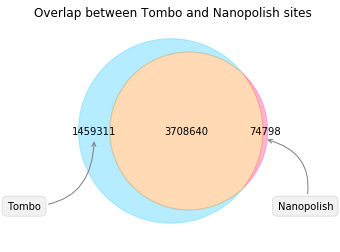

In [90]:
# First way to call the 2 group Venn diagram:
#The number of methylated CpG sites captured by Nanopolish:
#3783438
#The number of methylated CpG sites captured by Tombo on the forward strand:
#5167951
#The number of overlapping methylated CpG sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:
#3708640
c = tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']
a = tech_overlap_dict['5mC_hc_tombo_sorted.CpG.plus.bed']-tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']
b = tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']-tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']
v = venn2(subsets = (a, b, c), set_labels = (' ', ' '))
v.get_patch_by_id('01').set_color('#ff47a3')
v.get_patch_by_id('10').set_color('#47d1ff')
v.get_patch_by_id('11').set_color('#ffa347')
plt.annotate('Tombo', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70), \
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1), \
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('Nanopolish', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(40,-70), \
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1), \
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

plt.title('Overlap between Tombo and Nanopolish sites')
plt.show()

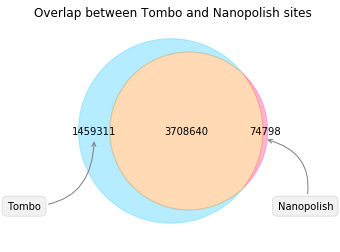

In [1531]:
# First way to call the 2 group Venn diagram:
#The number of methylated CpG sites captured by Nanopolish:
#3783438
#The number of methylated CpG sites captured by Tombo on the forward strand:
#5167951
#The number of overlapping methylated CpG sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:
#3708640
c = tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']
a = tech_overlap_dict['5mC_hc_tombo_sorted.CpG.plus.bed']-tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']
b = tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']-tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']
v = venn2(subsets = (a, b, c), set_labels = (' ', ' '))
v.get_patch_by_id('01').set_color('#ff47a3')
v.get_patch_by_id('10').set_color('#47d1ff')
v.get_patch_by_id('11').set_color('#ffa347')
plt.annotate('Tombo', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70), \
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1), \
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('Nanopolish', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(40,-70), \
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1), \
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

plt.title('Overlap between Tombo and Nanopolish sites')
plt.show()

In [ ]:
# Nanopore and PacBio Venn diagrams don't look good, since PacBio sites are 1% of Nanopore sites,
# so use the tombo nanopolish Venn diagram,
# and a table of percentages will be used

For the rest of the analysis, I will use the overlapped files for 5mC and 6mA data, and the Tombo files. This is because the Tombo files consider all possible A and C sites in the genome, and provide some consistency between the 6mA and 5mC data. In contrast, Nanopolish only detects 5mC at CpG sites on the forward strand, and SMRTLink does not provide a methylation-call accuracy value that is comparable to the accuracy in Nanopolis and Tombo. While Nanopolish and Tombo use the fraction of reads for the site that are methylated, SMRTLink uses a Phred score to determine methylation-call accuracy.

## <span style='color:#8a14ff'> 3. Making cutoff files. <span/>

### <span style='color:#8a14ff'> 3.A Making cutoff files from five original methylation-calling files, and intersect the two sequencing methods and the two methyaltion-callers. <span/>

In [44]:
# Make the list of cutoffs
cutoff_list = [1.00, 0.99, 0.95, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10, 0.00]

In [45]:
cutoff_list = sorted(cutoff_list)

In [46]:
len(cutoff_list)

13

In [196]:
# Define function to filter
def score_filter(feature, L):
    """Returns True if feature is longer than L"""
    return float(feature.score) >= L

def filter_by_cutoffs(bed_files, cutoffs, initial_file_path, final_file_path):
    """Filters files by the list of cutoffs given, and renames the file according to the cutoff."""
    for file in bed_files:
        pybed_object = BedTool(file)
        for x in cutoffs:
            filtered_file = pybed_object.filter(score_filter, x)
            cutoff = "{:.2f}".format(x)
            cutoff_name = '.cutoff.' + cutoff + '.bed'
            out_filename = file.replace('.bed', cutoff_name)
            out_filename = out_filename.replace(initial_file_path, final_file_path)
            filtered_file.saveas(out_filename)

In [ ]:
#Run the function to filter all files
initial_fp = '/home/anjuni/analysis/bedtools_output/sequencing_comparison/'
final_fp = '/home/anjuni/analysis/bedtools_output/cutoffs_from_intersects/'
filter_by_cutoffs(bed_file_list, cutoff_list, initial_fp, final_fp)

In [392]:
# make file handles for the four input files for intersecting, and the hc_tombo file for later analysis
sorted_bed_files = ['/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed']

In [ ]:
#Run the function to make cutoffs of all the sorted bed files
initial_fp1 = '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/'
final_fp1 = '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs/'
filter_by_cutoffs(sorted_bed_files, cutoff_list, initial_fp1, final_fp1)

In [200]:
%%bash

#Move the 6mA files and 5mC files to separate folders, to make running intersections easier
cd /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/
mkdir cutoffs_6mA
mkdir cutoffs_5mC
mv cutoffs/6mA* cutoffs_6mA
mv cutoffs/5mC* cutoffs_5mC
rmdir cutoffs

In [15]:
# make directories for 6mA and 5mC cutoff files
DIRS['BED_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs')
DIRS['6MA_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_6mA')
DIRS['5MC_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_5mC')

In [16]:
print(DIRS['BED_CUTOFFS'])
print(DIRS['6MA_CUTOFFS'])
print(DIRS['5MC_CUTOFFS'])

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC


In [17]:
# make a list of 6mA cutoff files from Nanopore and PacBio
ont_6mA = [fn for fn in glob.iglob('%s/6mA_hc_tombo*.bed' % DIRS['6MA_CUTOFFS'], recursive=True)]
pb_6mA = [fn for fn in glob.iglob('%s/6mA_prob_smrtlink*.bed' % DIRS['6MA_CUTOFFS'], recursive=True)]

#test out these lists by printing
print(*ont_6mA, sep='\n')
print(*pb_6mA, sep='\n')

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.90.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.60.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.30.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.80.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.70.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.20.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.10.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.40.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.99.bed
/

In [18]:
# make a list of 5mC cutoff files from Nanopolish and Tombo
np_5mC = [fn for fn in glob.iglob('%s/5mC_hc_nanopolish*.bed' % DIRS['5MC_CUTOFFS'], recursive=True)]
tombo_CpG_5mC = [fn for fn in glob.iglob('%s/5mC_hc_tombo_sorted.CpG.plus*.bed' % DIRS['5MC_CUTOFFS'], recursive=True)]
tombo_5mC = [fn for fn in glob.iglob('%s/5mC_hc_tombo_sorted.c*.bed' % DIRS['5MC_CUTOFFS'], recursive=True)]

#test out these lists by printing
print(*np_5mC, sep='\n')
print(*tombo_CpG_5mC, sep='\n')
print(*tombo_5mC, sep='\n')

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.90.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.60.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.00.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.80.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.40.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.50.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.10.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.20.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5

In [19]:
# the lists are not sorted, so sort them before doing cutoffs
ont_6mA = sorted(ont_6mA)
pb_6mA = sorted(pb_6mA)
np_5mC = sorted(np_5mC)
tombo_CpG_5mC = sorted(tombo_CpG_5mC)
tombo_5mC = sorted(tombo_5mC)

In [20]:
#Check if it worked. (It did!) :D
print(*ont_6mA, sep='\n')
print(*pb_6mA, sep='\n')
print(*np_5mC, sep='\n')
print(*tombo_CpG_5mC, sep='\n')
print(*tombo_5mC, sep='\n')

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.00.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.10.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.20.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.30.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.40.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.50.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.60.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.70.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.80.bed
/

In [436]:
# make the filepaths for intersects output
DIRS['I_FROM_C'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'intersects_from_cutoffs')

In [47]:
# make a for loop to take a list of cutoffs, and a list of -a files and a list of -b files to intersect
def intersect_cutoffs(list_a, list_b, n_cutoffs, mod, a_name, b_name):
    """Take a list of files and intersect them with another list of files, where files are matched by methylation cutoff. Other required inputs are the number of cutoffs in the list, the modification, and the names to be used in the outfile to signify the BED file from list a and b."""
    for i in range(n_cutoffs): # go through each element in the sorted list, pairing them up
        a_bed = BedTool(list_a[i])
        b_bed = BedTool(list_b[i])
        cutoff_suffix = list_a[i][-16:] # get cutoff value from one of the files
        out_name = mod + '_' + a_name + '_' + b_name + cutoff_suffix # make a new file name with the two intersected files, basemod type and cutoff
        out_file = os.path.join(DIRS['I_FROM_C'], out_name) # make the file path
        intersected_cutoff = a_bed.intersect(b_bed).saveas(out_file) # save out the intersected file

In [ ]:
# Run intersect cutoffs for 6mA and 5mC
intersect_cutoffs(ont_6mA, pb_6mA, 13, '6mA', 'tombo', 'smrtlink')
intersect_cutoffs(tombo_CpG_5mC, np_5mC, 13, '5mC', 'tombo', 'nanopolish')

In [ ]:
%%bash

# Make one directory that contains cutoffs of all 4 bed files for use in downstream analysis
cd /home/anjuni/analysis/coverage
mkdir feature_files
cp ../bedtools_output/intersects_from_cutoffs/* feature_files
cp ../../methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_tombo_sorted.cutoff.* feature_files
cp ../../methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.* feature_files

In [26]:
%%bash

#do the same for pb and np files
cd /home/anjuni/analysis/coverage
cp ../bedtools_output/intersects_from_cutoffs/* feature_files
cp ../../methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.* feature_files
cp ../../methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_prob_smrtlink_sorted.cutoff.* feature_files
cp ../../methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_tombo_sorted.CpG.plus.cutoff.* feature_files

In [9]:
# Make lists of cutoffs from each of the BED files for use in analysis in the new folder
# Remake the lists for the old ones under new names

# set filepaths for feature inputs
DIRS['FEATURES'] = os.path.join(DIRS['BASE2'], 'coverage', 'feature_files')

intersected_5mC = [fn for fn in glob.iglob('%s/5mC_t*.bed' % DIRS['FEATURES'], recursive=True)]
intersected_6mA = [fn for fn in glob.iglob('%s/6mA_t*.bed' % DIRS['FEATURES'], recursive=True)]
hc_tombo_5mC = [fn for fn in glob.iglob('%s/5mC_h*.bed' % DIRS['FEATURES'], recursive=True)]
hc_tombo_6mA = [fn for fn in glob.iglob('%s/6mA_h*.bed' % DIRS['FEATURES'], recursive=True)]

In [124]:
# Print lists to check they worked
pprint.pprint(intersected_5mC)
pprint.pprint(intersected_6mA)
pprint.pprint(hc_tombo_5mC)
pprint.pprint(hc_tombo_6mA)

['/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.10.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.90.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.50.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.20.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.99.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.40.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.70.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.80.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.00.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.30.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.95.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tom

In [74]:
table_pb_6mA = [fn for fn in glob.iglob('%s/6mA_p*.bed' % DIRS['FEATURES'], recursive=True)]
table_np_5mC = [fn for fn in glob.iglob('%s/5mC_hc_n*.bed' % DIRS['FEATURES'], recursive=True)]
table_tombo_CpG_5mC = [fn for fn in glob.iglob('%s/5mC_hc_tombo_sorted.C*.bed' % DIRS['FEATURES'], recursive=True)]

In [75]:
pprint.pprint(table_pb_6mA)
pprint.pprint(table_np_5mC)
pprint.pprint(table_tombo_CpG_5mC)

['/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.95.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.00.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.50.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.80.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.30.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.20.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.99.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.70.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.90.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.60.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.1.00.bed',
 '/home/an

In [125]:
# These lists are not sorted, so sort them before doing windows
intersected_5mC.sort()
intersected_6mA.sort()
hc_tombo_5mC.sort()
hc_tombo_6mA.sort()

In [126]:
# Print sorted lists to check they worked (they did! time for windows)
pprint.pprint(intersected_5mC)
pprint.pprint(intersected_6mA)
pprint.pprint(hc_tombo_5mC)
pprint.pprint(hc_tombo_6mA)

['/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.00.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.10.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.20.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.30.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.40.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.50.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.60.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.70.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.80.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.90.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.95.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tom

In [76]:
table_np_5mC.sort()
table_pb_6mA.sort()
table_tombo_CpG_5mC.sort()

In [77]:
pprint.pprint(table_pb_6mA)
pprint.pprint(table_np_5mC)
pprint.pprint(table_tombo_CpG_5mC)

['/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.00.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.10.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.20.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.30.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.40.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.50.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.60.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.70.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.80.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.90.bed',
 '/home/anjuni/analysis/coverage/feature_files/6mA_prob_smrtlink_sorted.cutoff.0.95.bed',
 '/home/an

### <span style='color:#8a14ff'> 3.B Making a table for the cutoff files. <span/>

In [40]:
# Gather the lists to be used as inputs
pprint.pprint(np_5mC)
pprint.pprint(tombo_CpG_5mC)
pprint.pprint(pb_6mA)
pprint.pprint(ont_6mA)
pprint.pprint(intersected_5mC)
pprint.pprint(intersected_6mA)

['/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.00.bed',
 '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.10.bed',
 '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.20.bed',
 '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.30.bed',
 '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.40.bed',
 '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.50.bed',
 '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.60.bed',
 '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.70.bed',
 '/home/anjuni/methylation_calling/pacbi

In [41]:
# Write the function to count sites
def make_site_count_list(fn_list):
    """This is a function that returns a list of the number of lines in a file, when a list of files is given as input."""
    site_count_list = []
    for fn in fn_list:
        count = 0
        with open(fn, 'r') as infile:
            for line in infile:
                count += 1
        site_count_list.append(count)
    return site_count_list

In [133]:
np_5mC_count_list = make_site_count_list(np_5mC)
tombo_CpG_5mC_count_list = make_site_count_list(tombo_CpG_5mC)
pb_6mA_count_list = make_site_count_list(pb_6mA)
ont_6mA_count_list = make_site_count_list(ont_6mA)
intersected_5mC_count_list = make_site_count_list(intersected_5mC)
intersected_6mA_count_list = make_site_count_list(intersected_6mA)

In [134]:
print(np_5mC_count_list)
print(tombo_CpG_5mC_count_list)
print(pb_6mA_count_list)
print(ont_6mA_count_list)
print(intersected_5mC_count_list)
print(intersected_6mA_count_list)

[3783438, 2655129, 2408326, 2329892, 2287038, 2249995, 2195581, 2122684, 1995419, 1597784, 1068255, 609093, 608808]
[5167951, 5123192, 4970628, 4660551, 4184707, 3511671, 2414941, 1380931, 681458, 249792, 140848, 120970, 120970]
[88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 68]
[83451878, 80777279, 73301535, 61332775, 47837744, 34554267, 19402593, 8986431, 3668473, 1333195, 928352, 882625, 882625]
[3708640, 2581835, 2313616, 2174002, 2025031, 1823390, 1439138, 953767, 502953, 151839, 53649, 30708, 30691]
[84733, 77694, 66199, 53979, 42461, 31857, 19602, 10085, 4457, 1380, 622, 507, 0]


In [128]:
# Make a list of percentage overlap
def make_percent_overlap_list(intersect_list, smaller_file_list):
    """Calculates percentage of intersection as a proportion of the smaller input file."""
    percent_list = []
    for i in range(len(intersect_list)):
        if intersect_list[i] == 0:
            percent = float(0)
            percent_list.append(percent)
        else:
            percent = intersect_list[i] / smaller_file_list[i]
            percent = 100*percent
            percent_list.append(percent)
    return percent_list

In [135]:
percent_overlap_5mC = make_percent_overlap_list(intersected_5mC_count_list, np_5mC_count_list)
percent_overlap_6mA = make_percent_overlap_list(intersected_6mA_count_list, pb_6mA_count_list)

In [136]:
cutoff_5mC = {}
cutoff_5mC['Tombo Sites'] = tombo_CpG_5mC_count_list
cutoff_5mC['Nanopolish Sites'] = np_5mC_count_list
cutoff_5mC['Overlapping Sites'] = intersected_5mC_count_list
cutoff_5mC['Methylated Fraction Cutoff'] = cutoff_list
cutoff_5mC['Percentage Overlap (%)'] = percent_overlap_5mC

In [137]:
cutoff_6mA = {}
cutoff_6mA['PacBio Sites'] = pb_6mA_count_list
cutoff_6mA['Nanopore Sites'] = ont_6mA_count_list
cutoff_6mA['Overlapping Sites'] = intersected_6mA_count_list
cutoff_6mA['Methylated Fraction Cutoff'] = cutoff_list
cutoff_6mA['Percentage Overlap (%)'] = percent_overlap_6mA

In [138]:
# Save the dataframes as csv files for 5mC and 6mA
df = pd.DataFrame.from_dict(cutoff_5mC)
df = df [['Methylated Fraction Cutoff', 'Tombo Sites', 'Nanopolish Sites', 'Overlapping Sites', 'Percentage Overlap (%)']]
df.to_csv(os.path.join(DIRS['FIGURES'], '5mC_cutoff_table'), header=True, index=None, sep='\t')

df = pd.DataFrame.from_dict(cutoff_6mA)
df = df [['Methylated Fraction Cutoff', 'Nanopore Sites', 'PacBio Sites', 'Overlapping Sites', 'Percentage Overlap (%)']]
df.to_csv(os.path.join(DIRS['FIGURES'], '6mA_cutoff_table'), header=True, index=None, sep='\t')

In [148]:
percent_overlap_6mA_tombo

[0.10153516257596983,
 0.09618298729770286,
 0.09031052351086508,
 0.08801004030879085,
 0.08876045659678267,
 0.0921941131033108,
 0.10102773376733719,
 0.11222475307494154,
 0.12149469275090753,
 0.10351073923919607,
 0.06700044810589087,
 0.05744228862767314,
 0.0]

In [151]:
percent_overlap_5mC_np = make_percent_overlap_list(intersected_5mC_count_list, np_5mC_count_list)
percent_overlap_6mA_pb = make_percent_overlap_list(intersected_6mA_count_list, pb_6mA_count_list)
percent_overlap_5mC_tombo = make_percent_overlap_list(intersected_5mC_count_list, tombo_CpG_5mC_count_list)
percent_overlap_6mA_tombo = make_percent_overlap_list(intersected_6mA_count_list, ont_6mA_count_list)

cutoff_5mC = {}
cutoff_5mC['Tombo Sites'] = tombo_CpG_5mC_count_list
cutoff_5mC['Nanopolish Sites'] = np_5mC_count_list
cutoff_5mC['Overlapping Sites'] = intersected_5mC_count_list
cutoff_5mC['Methylated Fraction Cutoff'] = cutoff_list
cutoff_5mC['Percentage Overlap of Nanopolish (%)'] = percent_overlap_5mC_np
cutoff_5mC['Percentage Overlap of Tombo (%)'] = percent_overlap_5mC_tombo

cutoff_6mA = {}
cutoff_6mA['PacBio Sites'] = pb_6mA_count_list
cutoff_6mA['Nanopore Sites'] = ont_6mA_count_list
cutoff_6mA['Overlapping Sites'] = intersected_6mA_count_list
cutoff_6mA['Methylated Fraction Cutoff'] = cutoff_list
cutoff_6mA['Percentage Overlap of PacBio (%)'] = percent_overlap_6mA_pb
cutoff_6mA['Percentage Overlap of Tombo (%)'] = percent_overlap_6mA_tombo

# Save the dataframes as csv files for 5mC and 6mA
df = pd.DataFrame.from_dict(cutoff_5mC)
df = df [['Methylated Fraction Cutoff', 'Tombo Sites', 'Nanopolish Sites', 'Overlapping Sites', 'Percentage Overlap of Nanopolish (%)', 'Percentage Overlap of Tombo (%)']]
df.to_csv(os.path.join(DIRS['FIGURES'], '5mC_cutoff_table.tsv'), header=True, index=None, sep='\t')

df = pd.DataFrame.from_dict(cutoff_6mA)
df = df [['Methylated Fraction Cutoff', 'Nanopore Sites', 'PacBio Sites', 'Overlapping Sites', 'Percentage Overlap of PacBio (%)', 'Percentage Overlap of Tombo (%)']]
df.to_csv(os.path.join(DIRS['FIGURES'], '6mA_cutoff_table.tsv'), header=True, index=None, sep='\t')

In [152]:
df = pd.DataFrame.from_dict(cutoff_6mA)
df = df [['Methylated Fraction Cutoff', 'Nanopore Sites', 'PacBio Sites', 'Overlapping Sites', 'Percentage Overlap of PacBio (%)', 'Percentage Overlap of Tombo (%)']]
df.to_csv(os.path.join(DIRS['FIGURES'], '6mA_cutoff_table.tsv'), header=True, index=None, sep='\t')

### <span style='color:#8a14ff'> 3.C Making random distributions of the same size as all the cutoff files. <span/>

In [34]:
# Inputs needed:

# file of all C in genome
all_c = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', '5mC_tombo_sorted.bed')
# file of all A in genome
all_a = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', '6mA_tombo_sorted.bed')
# file of all (+) strand CpG
all_cpg = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', '5mC_hc_tombo_sorted.CpG.plus.bed')

In [14]:
# Function to count the number of sites in each cutoff file
def count_sites(file_list):
    """Outputs a dictionary of each cutoff file and the number of sites it has."""
    count_dict = {}
    for file in file_list:
        with open(file) as in_file:
            count = 0
            for line in in_file:
                count += 1
        count_dict[file.split('/')[-1]] = count
    return count_dict

In [2]:
# Function to make the list of output randomisation file for each input cutoff file
def out_rand_files(file_list):
    """Outputs a dictionary of output randomisation file paths for a given list of input file paths."""
    rand_dict = {}
    for file in file_list:
        out_name = file.replace('.bed', '_rand.bed')
        out_name = out_name.replace('feature_files', 'randomisation')
        rand_dict[file.split('/')[-1]] = out_name
    return rand_dict

In [602]:
# Make count dictionaries separated by modification type
intersect_5mC_count_dict = count_sites(intersected_5mC)
intersect_6mA_count_dict = count_sites(intersected_6mA)
tombo_5mC_count_dict = count_sites(hc_tombo_5mC)
tombo_6mA_count_dict = count_sites(hc_tombo_6mA)

In [611]:
pprint.pprint(intersect_5mC_count_dict)
pprint.pprint(intersect_6mA_count_dict)
pprint.pprint(tombo_5mC_count_dict)
pprint.pprint(tombo_6mA_count_dict)

{'5mC_tombo_nanopolish.cutoff.0.00.bed': 3708640,
 '5mC_tombo_nanopolish.cutoff.0.10.bed': 2581835,
 '5mC_tombo_nanopolish.cutoff.0.20.bed': 2313616,
 '5mC_tombo_nanopolish.cutoff.0.30.bed': 2174002,
 '5mC_tombo_nanopolish.cutoff.0.40.bed': 2025031,
 '5mC_tombo_nanopolish.cutoff.0.50.bed': 1823390,
 '5mC_tombo_nanopolish.cutoff.0.60.bed': 1439138,
 '5mC_tombo_nanopolish.cutoff.0.70.bed': 953767,
 '5mC_tombo_nanopolish.cutoff.0.80.bed': 502953,
 '5mC_tombo_nanopolish.cutoff.0.90.bed': 151839,
 '5mC_tombo_nanopolish.cutoff.0.95.bed': 53649,
 '5mC_tombo_nanopolish.cutoff.0.99.bed': 30708,
 '5mC_tombo_nanopolish.cutoff.1.00.bed': 30691}
{'6mA_tombo_smrtlink.cutoff.0.00.bed': 84733,
 '6mA_tombo_smrtlink.cutoff.0.10.bed': 77694,
 '6mA_tombo_smrtlink.cutoff.0.20.bed': 66199,
 '6mA_tombo_smrtlink.cutoff.0.30.bed': 53979,
 '6mA_tombo_smrtlink.cutoff.0.40.bed': 42461,
 '6mA_tombo_smrtlink.cutoff.0.50.bed': 31857,
 '6mA_tombo_smrtlink.cutoff.0.60.bed': 19602,
 '6mA_tombo_smrtlink.cutoff.0.70.bed'

In [ ]:
# Make count distributions for the PacBio and Nanopolish files (for cutoff table)
pacbio_6mA_count_dict = count_sites(pb_6mA)
nanopolish_5mC_count_dict = count_sites(np_5mC)
tombo_CpG_5mC_count_dict = count_sites(tombo_CpG_5mC)

In [79]:
pprint.pprint(pacbio_6mA_count_dict)
pprint.pprint(nanopolish_5mC_count_dict)
pprint.pprint(tombo_CpG_5mC_count_dict)

{'6mA_prob_smrtlink_sorted.cutoff.0.00.bed': 88932,
 '6mA_prob_smrtlink_sorted.cutoff.0.10.bed': 88932,
 '6mA_prob_smrtlink_sorted.cutoff.0.20.bed': 88932,
 '6mA_prob_smrtlink_sorted.cutoff.0.30.bed': 88932,
 '6mA_prob_smrtlink_sorted.cutoff.0.40.bed': 88932,
 '6mA_prob_smrtlink_sorted.cutoff.0.50.bed': 88932,
 '6mA_prob_smrtlink_sorted.cutoff.0.60.bed': 88932,
 '6mA_prob_smrtlink_sorted.cutoff.0.70.bed': 88932,
 '6mA_prob_smrtlink_sorted.cutoff.0.80.bed': 88932,
 '6mA_prob_smrtlink_sorted.cutoff.0.90.bed': 88932,
 '6mA_prob_smrtlink_sorted.cutoff.0.95.bed': 88932,
 '6mA_prob_smrtlink_sorted.cutoff.0.99.bed': 88932,
 '6mA_prob_smrtlink_sorted.cutoff.1.00.bed': 68}
{'5mC_hc_nanopolish_sorted.cutoff.0.00.bed': 3783438,
 '5mC_hc_nanopolish_sorted.cutoff.0.10.bed': 2655129,
 '5mC_hc_nanopolish_sorted.cutoff.0.20.bed': 2408326,
 '5mC_hc_nanopolish_sorted.cutoff.0.30.bed': 2329892,
 '5mC_hc_nanopolish_sorted.cutoff.0.40.bed': 2287038,
 '5mC_hc_nanopolish_sorted.cutoff.0.50.bed': 2249995,
 '5

In [10]:
# Make dictionaries of out files for everything
intersect_5mC_rand_dict = out_rand_files(intersected_5mC)
intersect_6mA_rand_dict = out_rand_files(intersected_6mA)
tombo_5mC_rand_dict = out_rand_files(hc_tombo_5mC)
tombo_6mA_rand_dict = out_rand_files(hc_tombo_6mA)

In [31]:
pacbio_6mA_rand_dict = out_rand_files(table_pb_6mA)
nanopolish_5mC_rand_dict = out_rand_files(table_np_5mC)
tombo_CpG_5mC_rand_dict = out_rand_files(table_tombo_CpG_5mC)

In [ ]:
methyl_rand_dict = {}
methyl_rand_dict['5mC_hc_tombo_sorted.cutoff.0.00.bed'] = '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.00_rand.bed'
methyl_rand_dict['6mA_hc_tombo_sorted.cutoff.0.00.bed'] = '/home/anjuni/analysis/coverage/randomisation/6mA_hc_tombo_sorted.cutoff.0.00_rand.bed'
methyl_rand_dict['5mC_hc_tombo_sorted.cutoff.0.90.bed'] = '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.90_rand.bed'
methyl_rand_dict['6mA_hc_tombo_sorted.cutoff.0.90.bed'] = '/home/anjuni/analysis/coverage/randomisation/6mA_hc_tombo_sorted.cutoff.0.90_rand.bed'
methyl_rand_dict['5mC_hc_tombo_sorted.cutoff.0.99.bed'] = '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.99_rand.bed'
methyl_rand_dict['6mA_hc_tombo_sorted.cutoff.0.99.bed'] = '/home/anjuni/analysis/coverage/randomisation/6mA_hc_tombo_sorted.cutoff.0.99_rand.bed'
methyl_rand_dict['5mC_hc_tombo_sorted.cutoff.0.50.bed'] = '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.50_rand.bed'
methyl_rand_dict['6mA_hc_tombo_sorted.cutoff.0.50.bed'] = '/home/anjuni/analysis/coverage/randomisation/6mA_hc_tombo_sorted.cutoff.0.50_rand.bed'

In [13]:
pprint.pprint(intersect_5mC_rand_dict)
pprint.pprint(intersect_6mA_rand_dict)
pprint.pprint(tombo_5mC_rand_dict)
pprint.pprint(tombo_6mA_rand_dict)

{'5mC_tombo_nanopolish.cutoff.0.00.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.00_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.10.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.10_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.20.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.20_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.30.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.30_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.40.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.40_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.50.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.50_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.60.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.60_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.70.bed': '/home/anjuni/analysis/coverage/randomisat

In [81]:
pprint.pprint(pacbio_6mA_rand_dict)
pprint.pprint(nanopolish_5mC_rand_dict)
pprint.pprint(tombo_CpG_5mC_rand_dict)

{'6mA_prob_smrtlink_sorted.cutoff.0.00.bed': '/home/anjuni/analysis/coverage/randomisation/6mA_prob_smrtlink_sorted.cutoff.0.00_rand.bed',
 '6mA_prob_smrtlink_sorted.cutoff.0.10.bed': '/home/anjuni/analysis/coverage/randomisation/6mA_prob_smrtlink_sorted.cutoff.0.10_rand.bed',
 '6mA_prob_smrtlink_sorted.cutoff.0.20.bed': '/home/anjuni/analysis/coverage/randomisation/6mA_prob_smrtlink_sorted.cutoff.0.20_rand.bed',
 '6mA_prob_smrtlink_sorted.cutoff.0.30.bed': '/home/anjuni/analysis/coverage/randomisation/6mA_prob_smrtlink_sorted.cutoff.0.30_rand.bed',
 '6mA_prob_smrtlink_sorted.cutoff.0.40.bed': '/home/anjuni/analysis/coverage/randomisation/6mA_prob_smrtlink_sorted.cutoff.0.40_rand.bed',
 '6mA_prob_smrtlink_sorted.cutoff.0.50.bed': '/home/anjuni/analysis/coverage/randomisation/6mA_prob_smrtlink_sorted.cutoff.0.50_rand.bed',
 '6mA_prob_smrtlink_sorted.cutoff.0.60.bed': '/home/anjuni/analysis/coverage/randomisation/6mA_prob_smrtlink_sorted.cutoff.0.60_rand.bed',
 '6mA_prob_smrtlink_sorted.

In [33]:
# Make a function that takes number of subset sites, abspath of all_site file, and output name
# Then generate a random array of length subset from all sites
# Then loops over all_site file while outfile is open to write out lines whose number is part of the randamized array
def subset_sites(all_site_fn, number_of_subset_sites, out_fn):
    """This is a function that creates a BED file containing a subset of the total sites in the genome, with the size of the subset equal to an input cutoff file."""
    df = pd.read_csv(all_site_fn, sep='\t', header = None) #use up memory making a dataframe of the csv file, to avoid running through it for each base in each loop
    if type(number_of_subset_sites) == int and type(out_fn) == str:
            random_array = np.random.choice(df.shape[0], number_of_subset_sites)
            random_array.sort()
            df.iloc[random_array, :].to_csv(out_fn, header=None, index=None, sep='\t') #iloc[rows, columns]
    elif type(number_of_subset_sites) == dict and type(out_fn) == dict:
        for skey, svalue in number_of_subset_sites.items():
            for fkey, fvalue in out_fn.items():
                if skey == fkey:
                    random_array = np.random.choice(df.shape[0], svalue)
                    random_array.sort()
                    df.iloc[random_array, :].to_csv(fvalue, header=None, index=None, sep='\t') 

In [609]:
# Make randomisation files for everything :)
subset_sites(all_cpg, intersect_5mC_count_dict, intersect_5mC_rand_dict)
subset_sites(all_a, intersect_6mA_count_dict, intersect_6mA_rand_dict)
subset_sites(all_c, tombo_5mC_count_dict, tombo_5mC_rand_dict)
subset_sites(all_a, tombo_6mA_count_dict, tombo_6mA_rand_dict)

In [37]:
subset_sites(all_cpg, nanopolish_5mC_count_dict, nanopolish_5mC_rand_dict)
subset_sites(all_a, pacbio_6mA_count_dict, pacbio_6mA_rand_dict)
subset_sites(all_cpg, tombo_CpG_5mC_count_dict, tombo_CpG_5mC_rand_dict)

In [255]:
# make just the pacbio randomisation file I need
pb_rand_dict = {}
pb_count_dict = {}
pb_rand_dict['6mA_prob_smrtlink_sorted.cutoff.0.80.bed'] = '/home/anjuni/analysis/coverage/randomisation/6mA_prob_smrtlink_sorted.cutoff.0.80_rand.bed'
pb_count_dict['6mA_prob_smrtlink_sorted.cutoff.0.80.bed'] = 88932

In [257]:
subset_sites(all_a, pb_count_dict, pb_rand_dict)

In [83]:
# Make input lists for rand files
rand_np_5mC = [fn for fn in glob.iglob('%s/5mC_hc_n*.bed' % DIRS['RAND'], recursive=True)]
rand_tombo_5mC = [fn for fn in glob.iglob('%s/5mC_hc_t*.bed' % DIRS['RAND'], recursive=True)]
rand_pb_6mA = [fn for fn in glob.iglob('%s/6mA_p*.bed' % DIRS['RAND'], recursive=True)]
rand_tombo_6mA = [fn for fn in glob.iglob('%s/6mA_hc_t*.bed' % DIRS['RAND'], recursive=True)]
rand_tombo_CpG_5mC = [fn for fn in glob.iglob('%s/5mC_hc_tombo_sorted.C*.bed' % DIRS['RAND'], recursive=True)]

In [84]:
rand_np_5mC.sort()
rand_tombo_5mC.sort()
rand_pb_6mA.sort()
rand_tombo_6mA.sort()
rand_tombo_CpG_5mC.sort()

In [85]:
pprint.pprint(rand_np_5mC)
pprint.pprint(rand_pb_6mA)
pprint.pprint(rand_tombo_5mC)
pprint.pprint(rand_tombo_6mA)
pprint.pprint(rand_tombo_CpG_5mC)

['/home/anjuni/analysis/coverage/randomisation/5mC_hc_nanopolish_sorted.cutoff.0.00_rand.bed',
 '/home/anjuni/analysis/coverage/randomisation/5mC_hc_nanopolish_sorted.cutoff.0.10_rand.bed',
 '/home/anjuni/analysis/coverage/randomisation/5mC_hc_nanopolish_sorted.cutoff.0.20_rand.bed',
 '/home/anjuni/analysis/coverage/randomisation/5mC_hc_nanopolish_sorted.cutoff.0.30_rand.bed',
 '/home/anjuni/analysis/coverage/randomisation/5mC_hc_nanopolish_sorted.cutoff.0.40_rand.bed',
 '/home/anjuni/analysis/coverage/randomisation/5mC_hc_nanopolish_sorted.cutoff.0.50_rand.bed',
 '/home/anjuni/analysis/coverage/randomisation/5mC_hc_nanopolish_sorted.cutoff.0.60_rand.bed',
 '/home/anjuni/analysis/coverage/randomisation/5mC_hc_nanopolish_sorted.cutoff.0.70_rand.bed',
 '/home/anjuni/analysis/coverage/randomisation/5mC_hc_nanopolish_sorted.cutoff.0.80_rand.bed',
 '/home/anjuni/analysis/coverage/randomisation/5mC_hc_nanopolish_sorted.cutoff.0.90_rand.bed',
 '/home/anjuni/analysis/coverage/randomisation/5mC

In [ ]:
# make a for loop to take a list of cutoffs, and a list of -a files and a list of -b files to intersect
def intersect_rand_cutoffs(list_a, list_b, n_cutoffs, mod, a_name, b_name):
    """Take a list of files and intersect them with another list of files, where files are matched by methylation cutoff. Other required inputs are the number of cutoffs in the list, the modification, and the names to be used in the outfile to signify the BED file from list a and b."""
    for i in range(n_cutoffs): # go through each element in the sorted list, pairing them up
        a_bed = BedTool(list_a[i])
        b_bed = BedTool(list_b[i])
        cutoff_suffix = list_a[i][-21:] # get cutoff value from one of the files
        out_name = mod + '_' + a_name + '_' + b_name + cutoff_suffix # make a new file name with the two intersected files, basemod type and cutoff
        out_file = os.path.join(DIRS['I_FROM_C'], out_name) # make the file path
        intersected_cutoff = a_bed.intersect(b_bed).saveas(out_file) # save out the intersected file

In [ ]:
intersect_rand_cutoffs(rand_tombo_CpG_5mC, rand_np_5mC, 13, '5mC', 'tombo', 'nanopolish')
intersect_rand_cutoffs(rand_tombo_6mA, rand_pb_6mA, 13, '6mA', 'tombo', 'smrtlink')

In [38]:
# Function that gives a dictionary of each input filehandle
def file_name_dict(file_list):
    """Outputs a dictionary of input file paths for a given list of input file paths."""
    file_dict = {}
    for file in file_list:
        file_dict[file.split('/')[-1]] = file
    return file_dict

In [617]:
# Make file name dict
intersect_5mC_dict = file_name_dict(intersected_5mC)
intersect_6mA_dict = file_name_dict(intersected_6mA)
tombo_5mC_dict = file_name_dict(hc_tombo_5mC)
tombo_6mA_dict = file_name_dict(hc_tombo_6mA)

In [618]:
pprint.pprint(intersect_5mC_dict)
pprint.pprint(intersect_6mA_dict)
pprint.pprint(tombo_5mC_dict)
pprint.pprint(tombo_6mA_dict)

{'5mC_tombo_nanopolish.cutoff.0.00.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.00.bed',
 '5mC_tombo_nanopolish.cutoff.0.10.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.10.bed',
 '5mC_tombo_nanopolish.cutoff.0.20.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.20.bed',
 '5mC_tombo_nanopolish.cutoff.0.30.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.30.bed',
 '5mC_tombo_nanopolish.cutoff.0.40.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.40.bed',
 '5mC_tombo_nanopolish.cutoff.0.50.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.50.bed',
 '5mC_tombo_nanopolish.cutoff.0.60.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.60.bed',
 '5mC_tombo_nanopolish.cutoff.0.70.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.7

In [ ]:
pabcio_6mA_dict = file_name_dict()
nanopolish_5mC_dict = file_name_dict()

### <span style='color:#8a14ff'> 3.D Making a table for random distributions of the cutoff files. <span/>

In [98]:
# make lists of intersect file paths
rand_intersected_5mC = [fn for fn in glob.iglob('%s/5mC_*d.bed' % DIRS['I_FROM_C'], recursive=True)]
rand_intersected_6mA = [fn for fn in glob.iglob('%s/6mA_*d.bed' % DIRS['I_FROM_C'], recursive=True)]

In [99]:
rand_intersected_5mC.sort()
rand_intersected_6mA.sort()

In [100]:
pprint.pprint(rand_intersected_5mC)
pprint.pprint(rand_intersected_6mA)

['/home/anjuni/analysis/bedtools_output/intersects_from_cutoffs/5mC_tombo_nanopolish.cutoff.0.00_rand.bed',
 '/home/anjuni/analysis/bedtools_output/intersects_from_cutoffs/5mC_tombo_nanopolish.cutoff.0.10_rand.bed',
 '/home/anjuni/analysis/bedtools_output/intersects_from_cutoffs/5mC_tombo_nanopolish.cutoff.0.20_rand.bed',
 '/home/anjuni/analysis/bedtools_output/intersects_from_cutoffs/5mC_tombo_nanopolish.cutoff.0.30_rand.bed',
 '/home/anjuni/analysis/bedtools_output/intersects_from_cutoffs/5mC_tombo_nanopolish.cutoff.0.40_rand.bed',
 '/home/anjuni/analysis/bedtools_output/intersects_from_cutoffs/5mC_tombo_nanopolish.cutoff.0.50_rand.bed',
 '/home/anjuni/analysis/bedtools_output/intersects_from_cutoffs/5mC_tombo_nanopolish.cutoff.0.60_rand.bed',
 '/home/anjuni/analysis/bedtools_output/intersects_from_cutoffs/5mC_tombo_nanopolish.cutoff.0.70_rand.bed',
 '/home/anjuni/analysis/bedtools_output/intersects_from_cutoffs/5mC_tombo_nanopolish.cutoff.0.80_rand.bed',
 '/home/anjuni/analysis/bedt

In [102]:
# make lists of site counts
rand_np_5mC_count_list = make_site_count_list(rand_np_5mC)
rand_tombo_CpG_5mC_count_list = make_site_count_list(rand_tombo_CpG_5mC)
rand_pb_6mA_count_list = make_site_count_list(rand_pb_6mA)
rand_tombo_6mA_count_list = make_site_count_list(rand_tombo_6mA)
rand_intersected_5mC_count_list = make_site_count_list(rand_intersected_5mC)
rand_intersected_6mA_count_list = make_site_count_list(rand_intersected_6mA)

In [104]:
# Gather the lists to be used as inputs
print(rand_np_5mC_count_list)
print(rand_tombo_CpG_5mC_count_list)
print(rand_pb_6mA_count_list)
print(rand_tombo_6mA_count_list)
print(rand_intersected_5mC_count_list)
print(rand_intersected_6mA_count_list)

[3783438, 2655129, 2408326, 2329892, 2287038, 2249995, 2195581, 2122684, 1995419, 1597784, 1068255, 609093, 608808]
[5167951, 5123192, 4970628, 4660551, 4184707, 3511671, 2414941, 1380931, 681458, 249792, 140848, 120970, 120970]
[88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 68]
[83451878, 80777279, 73301535, 61332775, 47837744, 34554267, 19402593, 8986431, 3668473, 1333195, 928352, 882625, 882625]
[3784549, 2631916, 2317437, 2103183, 1853044, 1528201, 1025363, 567390, 263069, 77356, 29328, 14333, 14009]
[86488, 83703, 76216, 63935, 49243, 35533, 20270, 9300, 3751, 1358, 979, 935, 1]


In [153]:
rand_percent_overlap_5mC_np = make_percent_overlap_list(rand_intersected_5mC_count_list, rand_np_5mC_count_list)
rand_percent_overlap_6mA_pb = make_percent_overlap_list(rand_intersected_6mA_count_list, rand_pb_6mA_count_list)
rand_percent_overlap_5mC_tombo = make_percent_overlap_list(rand_intersected_5mC_count_list, rand_tombo_CpG_5mC_count_list)
rand_percent_overlap_6mA_tombo = make_percent_overlap_list(rand_intersected_6mA_count_list, rand_tombo_6mA_count_list)

In [158]:
rand_cutoff_5mC = {}
rand_cutoff_5mC['Tombo Sites'] = rand_tombo_CpG_5mC_count_list
rand_cutoff_5mC['Nanopolish Sites'] = rand_np_5mC_count_list
rand_cutoff_5mC['Overlapping Sites'] = rand_intersected_5mC_count_list
rand_cutoff_5mC['Methylated Fraction Cutoff'] = cutoff_list
rand_cutoff_5mC['Percentage Overlap of Nanopolish (%)'] = rand_percent_overlap_5mC_np
rand_cutoff_5mC['Percentage Overlap of Tombo (%)'] = rand_percent_overlap_5mC_tombo

rand_cutoff_6mA = {}
rand_cutoff_6mA['PacBio Sites'] = rand_pb_6mA_count_list
rand_cutoff_6mA['Nanopore Sites'] = rand_tombo_6mA_count_list
rand_cutoff_6mA['Overlapping Sites'] = rand_intersected_6mA_count_list
rand_cutoff_6mA['Methylated Fraction Cutoff'] = cutoff_list
rand_cutoff_6mA['Percentage Overlap of PacBio (%)'] = rand_percent_overlap_6mA_pb
rand_cutoff_6mA['Percentage Overlap of Tombo (%)'] = rand_percent_overlap_6mA_tombo

In [159]:
# Save the dataframes as csv files for 5mC and 6mA
df = pd.DataFrame.from_dict(rand_cutoff_5mC)
df = df [['Methylated Fraction Cutoff', 'Tombo Sites', 'Nanopolish Sites', 'Overlapping Sites', 'Percentage Overlap of Nanopolish (%)', 'Percentage Overlap of Tombo (%)']]
df.to_csv(os.path.join(DIRS['FIGURES'], '5mC_rand_cutoff_table.tsv'), header=True, index=None, sep='\t')

df = pd.DataFrame.from_dict(rand_cutoff_6mA)
df = df [['Methylated Fraction Cutoff', 'Nanopore Sites', 'PacBio Sites', 'Overlapping Sites', 'Percentage Overlap of PacBio (%)', 'Percentage Overlap of Tombo (%)']]
df.to_csv(os.path.join(DIRS['FIGURES'], '6mA_rand_cutoff_table.tsv'), header=True, index=None, sep='\t')

### <span style='color:#8a14ff'> 3.E Statistical tests on the overlap of the cutoff files. <span/>

In [ ]:
# make the contingency tables

# row 1 = obs overlap1, exp overlap1
# row 2 = obs overlap2, exp overlap2

In [207]:
def fisher_test(dict1, dict2, key1, key2, name, cutoff_list):
    """This function returns a dictionary of Fisher """
    fisher_dict = {}
    for i in range(len(dict1[key1])):
        cont = np.matrix( [ [ dict1[key1][i], dict2[key1][i] ], [dict1[key2][i],  dict2[key2][i] ] ])
        stat, p = fisher_exact(cont)
        fkey = name + '_' + str(cutoff_list[i])
        fisher_dict[fkey] = stat, p
    return fisher_dict

In [263]:
print(*cutoff_5mC, sep='\n')
print(*rand_cutoff_5mC, sep='\n')
print(*cutoff_6mA, sep='\n')
print(*rand_cutoff_6mA, sep='\n')

Tombo Sites
Nanopolish Sites
Overlapping Sites
Methylated Fraction Cutoff
Percentage Overlap of Nanopolish (%)
Percentage Overlap of Tombo (%)
Tombo Sites
Nanopolish Sites
Overlapping Sites
Methylated Fraction Cutoff
Percentage Overlap of Nanopolish (%)
Percentage Overlap of Tombo (%)
PacBio Sites
Nanopore Sites
Overlapping Sites
Methylated Fraction Cutoff
Percentage Overlap of PacBio (%)
Percentage Overlap of Tombo (%)
PacBio Sites
Nanopore Sites
Overlapping Sites
Methylated Fraction Cutoff
Percentage Overlap of PacBio (%)
Percentage Overlap of Tombo (%)


In [208]:
fisher_5mC_cutoff = fisher_test(cutoff_5mC, rand_cutoff_5mC, 'Percentage Overlap of Nanopolish (%)', 'Percentage Overlap of Tombo (%)', '5mC', cutoff_list)
fisher_6mA_cutoff = fisher_test(cutoff_6mA, rand_cutoff_6mA, 'Percentage Overlap of PacBio (%)', 'Percentage Overlap of Tombo (%)', '6mA', cutoff_list)

In [210]:
pprint.pprint(fisher_5mC_cutoff)
pprint.pprint(fisher_6mA_cutoff)

{'5mC_0.0': (1.007605633802817, 1.0),
 '5mC_0.1': (0.9993939393939394, 1.0),
 '5mC_0.2': (1.0, 1.0),
 '5mC_0.3': (1.0108695652173914, 1.0),
 '5mC_0.4': (0.9958847736625515, 1.0),
 '5mC_0.5': (1.019315188762072, 1.0),
 '5mC_0.6': (1.0058953574060427, 1.0),
 '5mC_0.7': (1.0055741360089185, 1.0),
 '5mC_0.8': (1.0010537407797682, 1.0),
 '5mC_0.9': (1.125, 1.0),
 '5mC_0.95': (1.3157894736842106, 1.0),
 '5mC_0.99': (1.1, 1.0),
 '5mC_1.0': (1.1, 1.0)}
{'6mA_0.0': (nan, 1.0),
 '6mA_0.1': (nan, 1.0),
 '6mA_0.2': (nan, 1.0),
 '6mA_0.3': (nan, 1.0),
 '6mA_0.4': (nan, 1.0),
 '6mA_0.5': (nan, 1.0),
 '6mA_0.6': (nan, 1.0),
 '6mA_0.7': (nan, 1.0),
 '6mA_0.8': (nan, 1.0),
 '6mA_0.9': (nan, 1.0),
 '6mA_0.95': (nan, 1.0),
 '6mA_0.99': (nan, 1.0),
 '6mA_1.0': (nan, 1.0)}


In [211]:
%%bash

cd /home/anjuni/analysis/figures/cutoff_tables
cat 6mA_cutoff_table.tsv

Methylated Fraction Cutoff	Nanopore Sites	PacBio Sites	Overlapping Sites	Percentage Overlap of PacBio (%)	Percentage Overlap of Tombo (%)
0.0	83451878	88932	84733	95.27841496874017	0.10153516257596983
0.1	80777279	88932	77694	87.36337876130077	0.09618298729770286
0.2	73301535	88932	66199	74.43777268025008	0.09031052351086508
0.3	61332775	88932	53979	60.696936985562	0.08801004030879085
0.4	47837744	88932	42461	47.745468447802814	0.08876045659678267
0.5	34554267	88932	31857	35.821751450546486	0.0921941131033108
0.6	19402593	88932	19602	22.041559843475913	0.10102773376733719
0.7	8986431	88932	10085	11.340125039355913	0.11222475307494154
0.8	3668473	88932	4457	5.011694328250798	0.12149469275090753
0.9	1333195	88932	1380	1.5517474025097828	0.10351073923919607
0.95	928352	88932	622	0.699410785768902	0.06700044810589087
0.99	882625	88932	507	0.5700985022264202	0.05744228862767314
1.0	882625	68	0	0.0	0.0


In [212]:
%%bash

cd /home/anjuni/analysis/figures/cutoff_tables
cat 6mA_rand_cutoff_table.tsv

Methylated Fraction Cutoff	Nanopore Sites	PacBio Sites	Overlapping Sites	Percentage Overlap of PacBio (%)	Percentage Overlap of Tombo (%)
0.0	83451878	88932	86488	97.25183286106238	0.10363817097081986
0.1	80777279	88932	83703	94.12022669005532	0.10362196032872066
0.2	73301535	88932	76216	85.70143480412	0.10397599449997875
0.3	61332775	88932	63935	71.89200737642244	0.10424279677545976
0.4	47837744	88932	49243	55.371519812890746	0.10293754655319866
0.5	34554267	88932	35533	39.95524670534791	0.10283245192265257
0.6	19402593	88932	20270	22.792695542661807	0.1044705725672852
0.7	8986431	88932	9300	10.457428147348535	0.10348936079295551
0.8	3668473	88932	3751	4.21782935276391	0.10224962811502224
0.9	1333195	88932	1358	1.5270094004407864	0.10186056803393351
0.95	928352	88932	979	1.100841092070346	0.10545568922132983
0.99	882625	88932	935	1.0513650879323528	0.10593400368219799
1.0	882625	68	1	1.4705882352941175	0.0001132983996601048
